#Focus Algorithm for Pong


### algorithm based on :
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3283495/


In [ ]:
#Getting some data from sample dataset due to lack of availability of focus data outside of ADHD diagnosis
!pip install mne
import mne
import numpy as np
data_path = mne.datasets.sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
raw_data = mne.io.read_raw_fif(raw_fname, preload=True) 
raw_data.set_eeg_reference()
#picking eeg data only
raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Removing existing average EEG reference projection.
Created an SSP operator (subspace dimension = 3)
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


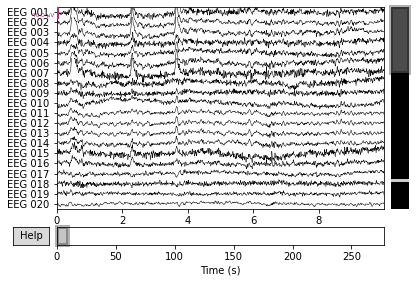

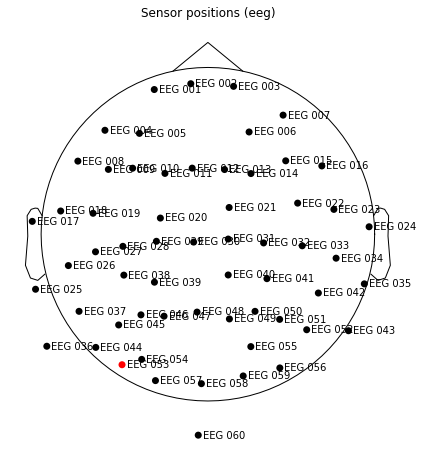

<Info | 15 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: True
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: []
 sfreq: 150.2 Hz
>

In [ ]:
#plotting data
raw_data.plot()
raw_channel_names= raw_data.ch_names
raw_data.plot_sensors(show_names=raw_channel_names[0:60])
#obtain info on data
raw_data.info

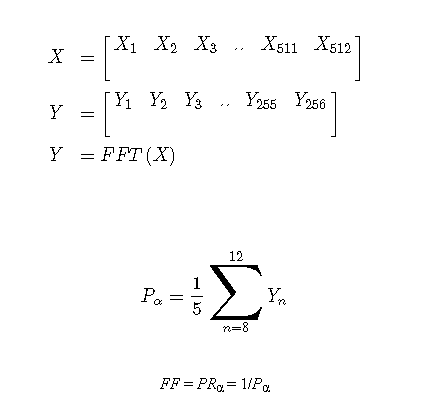

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


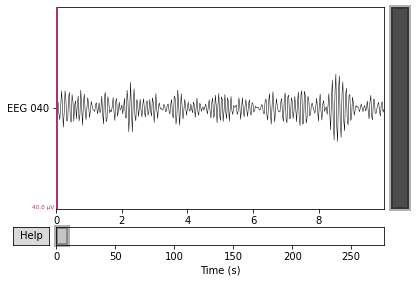

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 249 samples (1.658 sec)

The BFF is 3640.529870002242
The FF for this randomly chosen window is 10353.668394600589


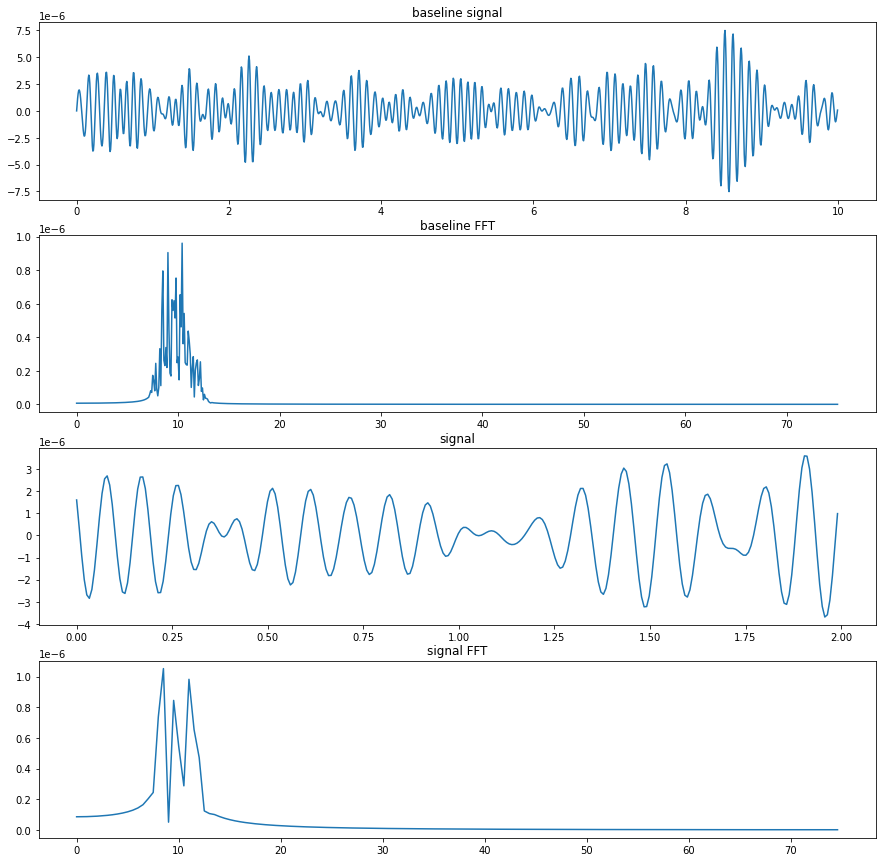

In [ ]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

#picking one channel to experiment algorithm on
#bandpass signal to get alpha band data using FFT and then getting a Focused Feature from Average
pick_data = raw_data.pick_channels(["EEG 040"])
pick_data.plot()
pick_data.filter(8,12, verbose=None)

#convert into ndarray
T = 1/150.2
d_040 = pick_data._data
d_040.shape
baseline_timepoints = d_040[0][0:1502] #timepoints for baseline FF/ BFF
timepoints = d_040[0][760:1060] #results in 2 seconds due to sampling rate, but for 250 Hz it would give a 2s window for FF 512 timepoints but here it is 300 time points
tff = np.linspace(0,T*len(timepoints),len(timepoints), endpoint=False)
tbff = np.linspace(0, T*len(baseline_timepoints), len(baseline_timepoints), endpoint=False)
ft = fft(timepoints)
bft =fft(baseline_timepoints)
bs = fftfreq(len(baseline_timepoints), T)[:len(baseline_timepoints)//2]
fs = fftfreq(len(timepoints), T)[:len(timepoints)//2]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols=1, figsize = (15,15))
baselineplot = ax1.plot(tbff, baseline_timepoints)
ax1.set(title = "baseline signal")
baselinefft = ax2.plot(bs, 2.0/len(baseline_timepoints) * np.abs(bft[0:len(baseline_timepoints)//2])) 
ax2.set(title = "baseline FFT")
signalplot = ax3.plot(tff, timepoints)
ax3.set(title = "signal")
baselinefft = ax4.plot(fs, 2.0/len(timepoints) * np.abs(ft[0:len(timepoints)//2])) 
ax4.set(title = "signal FFT")


#compute focused feature from fft

bff = 1/np.mean(np.abs(bft[80:120]))
print(f"The BFF is {bff}")
ff = 1/np.mean(np.abs(ft[16:24]))
print(f"The FF for this randomly chosen window is {ff}")




In [ ]:
#algorithm to compute FF of 2 second signal

def get_FF(inputsignal):
  '''
  Returns the focused feature of the signal of 150.2 Hz
  '''

  fourier_coeffs = fft(inputsignal)
  p_alpha = np.mean(np.abs(fourier_coeffs[16:24]))
  focusfeature = 1/p_alpha

  return focusfeature/2.7

#algorithm to compute BFF of 10 second signal

def get_BFF(basesignal):
  '''
  Returns the baseline focused feature of the signal of 150.2 Hz
  '''

  fourier_coeffs = fft(basesignal)
  p_alpha = np.mean(np.abs(fourier_coeffs[80:120]))
  focusfeature = 1/p_alpha

  return focusfeature


def parse_input(focusfeature, baselinefocusfeature):
  '''
  Parses input based on features, 1 denotes upward, 0 denotes downwards
  '''

  a = focusfeature
  b = baselinefocusfeature

  if a > b:
    return 1 #this represents up
  else:
    return 0 #this represents down

Example use case

In [ ]:
from time import sleep
sample_data = open("sample_eeg_pong_data.txt", "w+")
for p in d_040[0]:
  sample_data.write(str(p) + "\n")

with open("sample_eeg_pong_data.txt", "r") as file: 
    data = file.readlines()
    count = 0;
    signalwindow = []
    baselinewindow = []
    for line in data: 
        if count < 500:
          pass
        elif count < 2003:
          baselinewindow.append(float(line))
        elif count < 2303:
          signalwindow.append(float(line))
        else: 
          signalwindow.pop(0)
          signalwindow.append(float(line))
          print(parse_input(get_FF(signalwindow), get_BFF(baselinewindow)))
        sleep(1/150)
        count += 1

sample_data.close()

Streaming output truncated to the last 5000 lines.
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

KeyboardInterrupt: ignored

In [ ]:
#example use of PySerial to Interface with Arduino
import serial

ser = serial.Serial('COM4', baudrate = 115200, timeout = 1/150.2) #timeout is based on sampling rate
data = open("eeg_pong_data.txt", "w+") #the file that would be read from

while True:
  data.write(ser.readline() + "\n")

data.close()


ModuleNotFoundError: ignored

In [ ]:
import time
import numpy as np
from scipy.fft import fft

#defining functions
def get_FF(inputsignal):
  '''
  Returns the focused feature of the signal of 150.2 Hz
  '''

  fourier_coeffs = fft(inputsignal)
  p_alpha = np.mean(np.abs(fourier_coeffs[16:24]))
  focusfeature = 1/p_alpha

  return focusfeature/2.7

#algorithm to compute BFF of 10 second signal

def get_BFF(basesignal):
  '''
  Returns the baseline focused feature of the signal of 150.2 Hz
  '''

  fourier_coeffs = fft(basesignal)
  p_alpha = np.mean(np.abs(fourier_coeffs[80:120]))
  focusfeature = 1/p_alpha

  return focusfeature


def parse_input(focusfeature, baselinefocusfeature):
  '''
  Parses input based on features, 1 denotes upward, 0 denotes downwards
  '''

  a = focusfeature
  b = baselinefocusfeature

  if a > b:
    return 1 #this represents up
  else:
    return 0 #this represents down

#eeg_pong_data is the txt file being written from PySerial in an actual application case

with open("sample_eeg_pong_data.txt", "r") as file: 
    data = file.readlines()
    count = 0;
    signalwindow = []
    baselinewindow = []
    for line in data: 
        if count < 500:
          pass
        elif count < 2003:
          baselinewindow.append(float(line))
        elif count < 2303:
          signalwindow.append(float(line))
        else: 
          signalwindow.pop(0)
          signalwindow.append(float(line))
          print(parse_input(get_FF(signalwindow), get_BFF(baselinewindow)))
        sleep(1/150)
        count += 1

sample_data.close()


